# Basic Feature Engineering

In this phase we build matchup-level features for tournament games (for both men's and women's data) using the LR‐specific functions from pre_processing.py.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust module path based on environment
if os.path.exists('/kaggle/input'):
    sys.path.append('/kaggle/input/preprocessing-module')
else:
    sys.path.append('../../scripts')

# Import unified functions
from pre_processing import build_model_pipeline

# Additional imports for modeling and analysis
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import shap
from itertools import combinations

Men's Data – Matchup Feature Engineering

In [2]:
m_X, m_y, m_game_ids = build_model_pipeline(model_type='lr_basic', combine=False, gender='M')
print("Men's Matchup Features (LR):")
print(m_X.head(3))

Men's Matchup Features (LR):
   Season  Team1ID  Team2ID  Team1Seed  Team2Seed  Team1WinPct  Team2WinPct  \
0    1985     1116     1234          9          8     0.636364     0.666667   
1    1985     1120     1345         11          6     0.620690     0.680000   
2    1985     1207     1250          1         16     0.925926     0.379310   

   Team1AvgMargin  Team2AvgMargin  SeedDiff  WinPctDiff  AvgMarginDiff  
0        3.636364       10.466667         1   -0.030303      -6.830303  
1        3.689655        3.800000         5   -0.059310      -0.110345  
2       15.666667       -4.448276       -15    0.546616      20.114943  


Men's Data - Visualizations

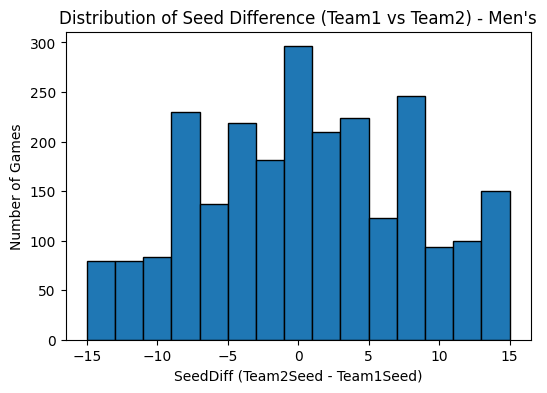

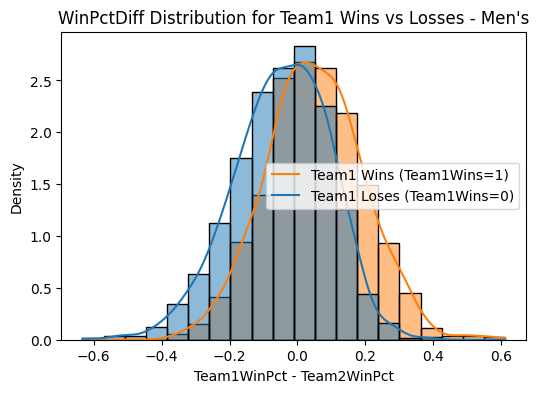

Men's matchup feature correlations:
SeedDiff        -0.490
WinPctDiff       0.325
AvgMarginDiff    0.396
Team1Wins        1.000
Name: Team1Wins, dtype: float64


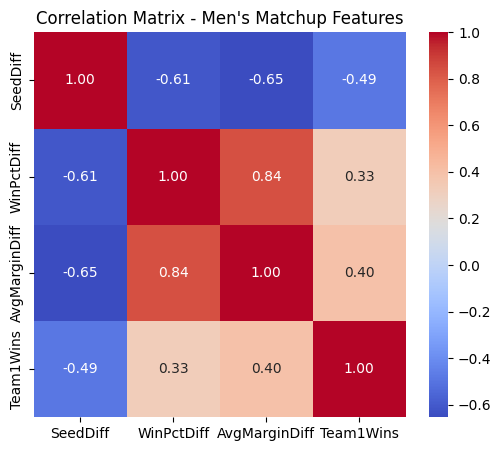

In [3]:
plt.figure(figsize=(6, 4))
plt.hist(m_X['SeedDiff'], bins=15, edgecolor='black')
plt.title("Distribution of Seed Difference (Team1 vs Team2) - Men's")
plt.xlabel("SeedDiff (Team2Seed - Team1Seed)")
plt.ylabel("Number of Games")
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(x=m_X['WinPctDiff'], hue=m_y, data=m_X, bins=20, kde=True, stat="density", common_norm=False)
plt.title("WinPctDiff Distribution for Team1 Wins vs Losses - Men's")
plt.xlabel("Team1WinPct - Team2WinPct")
plt.legend(labels=["Team1 Wins (Team1Wins=1)", "Team1 Loses (Team1Wins=0)"])
plt.show()

feature_corr_m = pd.concat([m_X[['SeedDiff', 'WinPctDiff', 'AvgMarginDiff']], m_y.rename('Team1Wins')], axis=1).corr()
print("Men's matchup feature correlations:")
print(feature_corr_m['Team1Wins'].round(3))

plt.figure(figsize=(6, 5))
corr_m = pd.concat([m_X[['SeedDiff', 'WinPctDiff', 'AvgMarginDiff']], m_y.rename('Team1Wins')], axis=1).corr()
sns.heatmap(corr_m, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix - Men's Matchup Features")
plt.show()

Women's Data – Matchup Feature Engineering

In [4]:
w_X, w_y, w_game_ids = build_model_pipeline(model_type='lr_basic', combine=False, gender='W')
print("Women's Matchup Features (LR):")
print(w_X.head(3))

Women's Matchup Features (LR):
   Season  Team1ID  Team2ID  Team1Seed  Team2Seed  Team1WinPct  Team2WinPct  \
0    1998     3104     3422          2         15     0.700000     0.703704   
1    1998     3112     3365          3         14     0.777778     0.785714   
2    1998     3163     3193          2         15     0.937500     0.714286   

   Team1AvgMargin  Team2AvgMargin  SeedDiff  WinPctDiff  AvgMarginDiff  
0       13.433333        6.111111       -13   -0.003704       7.322222  
1       12.407407       17.821429       -11   -0.007937      -5.414021  
2       24.875000        5.071429       -13    0.223214      19.803571  


Women's Data - Visualizations

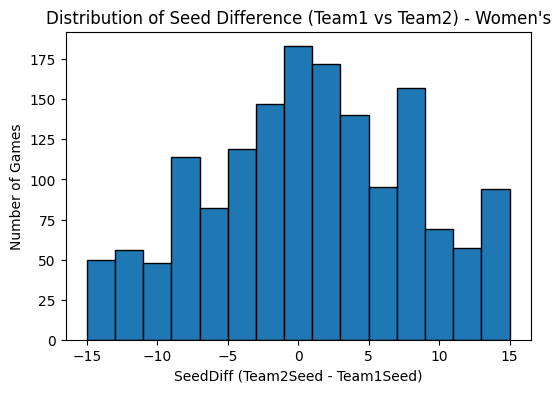

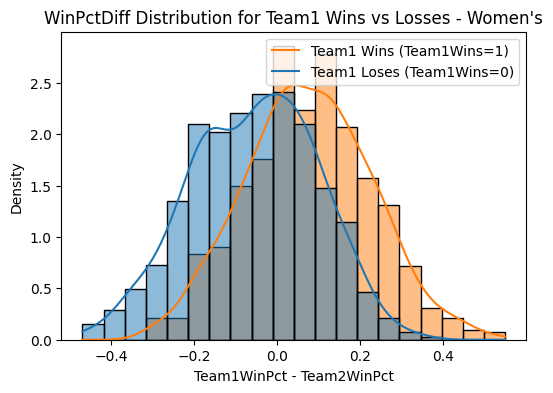

Women's matchup feature correlations:
SeedDiff        -0.619
WinPctDiff       0.399
AvgMarginDiff    0.489
Team1Wins        1.000
Name: Team1Wins, dtype: float64


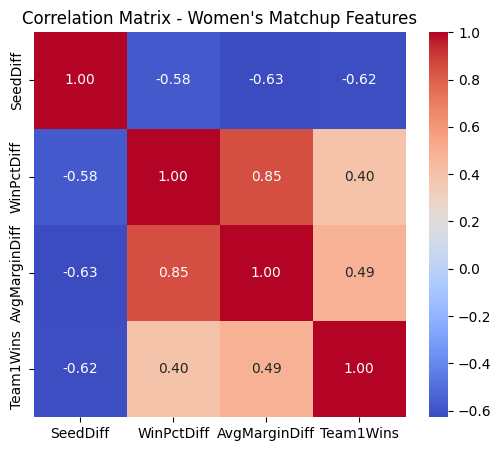

In [5]:
# Plot distribution of SeedDiff for women's matchups
plt.figure(figsize=(6, 4))
plt.hist(w_X['SeedDiff'], bins=15, edgecolor='black')
plt.title("Distribution of Seed Difference (Team1 vs Team2) - Women's")
plt.xlabel("SeedDiff (Team2Seed - Team1Seed)")
plt.ylabel("Number of Games")
plt.show()

# Plot histogram for WinPctDiff by outcome (Team1Wins)
plt.figure(figsize=(6, 4))
sns.histplot(x=w_X['WinPctDiff'], hue=w_y, data=w_X, bins=20, kde=True, stat="density", common_norm=False)
plt.title("WinPctDiff Distribution for Team1 Wins vs Losses - Women's")
plt.xlabel("Team1WinPct - Team2WinPct")
plt.legend(labels=["Team1 Wins (Team1Wins=1)", "Team1 Loses (Team1Wins=0)"])
plt.show()

# Compute and print correlations for women's matchup features
feature_corr_w = pd.concat([w_X[['SeedDiff', 'WinPctDiff', 'AvgMarginDiff']], w_y.rename('Team1Wins')], axis=1).corr()
print("Women's matchup feature correlations:")
print(feature_corr_w['Team1Wins'].round(3))

# Correlation Matrix Heatmap for Women's Matchup Features
plt.figure(figsize=(6, 5))
corr_w = pd.concat([w_X[['SeedDiff', 'WinPctDiff', 'AvgMarginDiff']], w_y.rename('Team1Wins')], axis=1).corr()
sns.heatmap(corr_w, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix - Women's Matchup Features")
plt.show()

# Baseline Modeling (Logistic Regression)

In this phase we establish a baseline logistic regression model.
We train separate models for men's and women's data and then on the combined dataset,
using the three difference-based features: SeedDiff, WinPctDiff, and AvgMarginDiff.

In [6]:
from pre_processing import rolling_window_cv
from sklearn.preprocessing import StandardScaler

# Global start season for rolling window cross validation
start_season = 2010

# --- new imports needed in this cell ---
from sklearn.preprocessing import StandardScaler

def lr_model_fn(X_train, y_train, X_test, y_test, test_season,
                model_params=None, sample_weight=None):
    """
    Train + evaluate a Logistic Regression with per-fold feature scaling.

    * A StandardScaler is **fit on X_train only**, then applied to both
      X_train and X_test – this eliminates the scaling leakage that
      occurred when features were scaled once at data-build time.
    * Probabilities are min-max normalised (same as before) so the
      downstream scoring code is unchanged.
    """
    if model_params is None:
        model_params = {}

    # enforce liblinear when l1 is requested (same guard as before)
    if model_params.get("penalty") == "l1" and "solver" not in model_params:
        model_params["solver"] = "liblinear"
    if "solver" not in model_params:
        model_params["solver"] = "liblinear"

    # # --- NEW: fold-specific scaling --------------------------------------
    # scaler = StandardScaler().fit(X_train)          # fit on training rows only
    # X_train_scaled = scaler.transform(X_train)
    # X_test_scaled  = scaler.transform(X_test)
    # # ---------------------------------------------------------------------

    model = LogisticRegression(**model_params)
    if sample_weight is not None:
        model.fit(X_train, y_train, sample_weight=sample_weight)
    else:
        model.fit(X_train, y_train)

    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # keep the post-hoc min-max normalisation you already had
    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-8)

    acc  = accuracy_score(y_test, y_pred)
    ll   = log_loss(y_test, y_proba)
    bri  = brier_score_loss(y_test, y_proba)
    return {"accuracy": acc, "logloss": ll, "brier": bri}


In [7]:
# Define baseline features (exactly as in the Random Forest version)
features_baseline = ['SeedDiff', 'WinPctDiff', 'AvgMarginDiff']

# For Men's data:
print("Men's Baseline Modeling with Rolling Window CV:")
cv_metrics_men = rolling_window_cv(
    X=m_X[["Season"] + features_baseline],
    y=m_y,
    start_season=start_season,
    window_size=None,  # use all available data prior to the test season
    model_fn=lr_model_fn,
    verbose=True
)

# For Women's data:
print("\nWomen's Baseline Modeling with Rolling Window CV:")
cv_metrics_women = rolling_window_cv(
    X=w_X[["Season"] + features_baseline],
    y=w_y,
    start_season=start_season,
    window_size=None,
    model_fn=lr_model_fn,
    verbose=True
)

# For Combined Basic Data:
combined_X = pd.concat([m_X, w_X], axis=0, ignore_index=True)
combined_y = pd.concat([m_y, w_y], axis=0, ignore_index=True)
print("\nCombined Basic Baseline Modeling with Rolling Window CV (No Elo Ratings):")
cv_metrics_combined_basic = rolling_window_cv(
    X=combined_X[["Season"] + features_baseline],
    y=combined_y,
    start_season=start_season,
    window_size=None,
    model_fn=lr_model_fn,
    verbose=True
)

Men's Baseline Modeling with Rolling Window CV:
Season 2011 – Accuracy: 0.672, Log Loss: 0.624, Brier: 0.219
Season 2012 – Accuracy: 0.701, Log Loss: 0.586, Brier: 0.197
Season 2013 – Accuracy: 0.672, Log Loss: 0.631, Brier: 0.220
Season 2014 – Accuracy: 0.627, Log Loss: 0.619, Brier: 0.221
Season 2015 – Accuracy: 0.761, Log Loss: 0.503, Brier: 0.166
Season 2016 – Accuracy: 0.716, Log Loss: 0.802, Brier: 0.196
Season 2017 – Accuracy: 0.761, Log Loss: 0.516, Brier: 0.177
Season 2018 – Accuracy: 0.642, Log Loss: 0.657, Brier: 0.218
Season 2019 – Accuracy: 0.716, Log Loss: 0.503, Brier: 0.173
Season 2021 – Accuracy: 0.682, Log Loss: 0.645, Brier: 0.227

Overall average metrics: Accuracy: 0.695, Log Loss: 0.609, Brier: 0.202

Women's Baseline Modeling with Rolling Window CV:
Season 2011 – Accuracy: 0.762, Log Loss: 0.403, Brier: 0.138
Season 2012 – Accuracy: 0.841, Log Loss: 0.401, Brier: 0.124
Season 2013 – Accuracy: 0.778, Log Loss: 0.446, Brier: 0.148
Season 2014 – Accuracy: 0.810, Log 

# Iterative Feature Selection & Refinement

In this phase we extend our baseline by incorporating Elo ratings, symmetrizing the dataset,
normalizing key difference features, and then performing advanced feature selection methods.
This phase includes:
 - Incorporating Elo ratings into the matchup features.
 - Symmetrizing the dataset.
 - Normalizing key features (SeedDiff, WinPctDiff, AvgMarginDiff, EloDiff).
 - LassoCV feature evaluation.
 - Recursive Feature Elimination (RFE) with Logistic Regression and Random Forest.
 - SHAP analysis to interpret feature contributions.
 - Weighted decay cross-validation experiments.
 - Final comparisons including data cut experiments.

Step 1: Advanced Feature Engineering with Elo Ratings

In [8]:
updated_X, updated_y, updated_game_ids = build_model_pipeline(model_type='lr')

print("Combined updated matchup features shape:", updated_X.shape)
print("Normalized updated matchup features preview:")
print(updated_X.head())

Combined updated matchup features shape: (8068, 15)
Normalized updated matchup features preview:
   Season  Team1ID  Team2ID  Team1Seed  Team2Seed  Team1WinPct  Team2WinPct  \
0    1985     1116     1234          9          8     0.636364     0.666667   
1    1985     1120     1345         11          6     0.620690     0.680000   
2    1985     1207     1250          1         16     0.925926     0.379310   
3    1985     1229     1425          9          8     0.740741     0.678571   
4    1985     1242     1325          3         14     0.766667     0.740741   

   Team1AvgMargin  Team2AvgMargin  SeedDiff  WinPctDiff  AvgMarginDiff  \
0        3.636364       10.466667         1   -0.030303      -6.830303   
1        3.689655        3.800000         5   -0.059310      -0.110345   
2       15.666667       -4.448276       -15    0.546616      20.114943   
3        5.962963        3.785714         1    0.062169       2.177249   
4        5.633333        4.555556       -11    0.025926   

Step 2: Lasso Feature Evaluation and RFE

In [9]:
X_phase4 = updated_X[['SeedDiff', 'WinPctDiff', 'AvgMarginDiff', 'EloDiff']]
y_phase4 = updated_y.astype(float)
scaler_phase4 = StandardScaler()
X_phase4_scaled = scaler_phase4.fit_transform(X_phase4)
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_phase4_scaled, y_phase4)
coef = pd.Series(lasso_cv.coef_, index=X_phase4.columns)
print("Lasso coefficients:", coef.round(3).to_dict())
print("Selected (non-zero) features:", list(coef[coef != 0].index))


log_clf = LogisticRegression(solver='liblinear')
rfe = RFE(estimator=log_clf, n_features_to_select=1)
rfe.fit(X_phase4, y_phase4)
print("RFE feature ranking (Logistic Regression):")
for feat, rank in zip(['SeedDiff', 'WinPctDiff', 'AvgMarginDiff', 'EloDiff'], rfe.ranking_):
    print(f"{feat}: rank {rank}")

rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
rfe_rf = RFE(estimator=rf_clf, n_features_to_select=1)
rfe_rf.fit(X_phase4, y_phase4)
print("RFE feature ranking (Random Forest):")
for feat, rank in zip(['SeedDiff', 'WinPctDiff', 'AvgMarginDiff', 'EloDiff'], rfe_rf.ranking_):
    print(f"{feat}: rank {rank}")

Lasso coefficients: {'SeedDiff': -0.206, 'WinPctDiff': -0.159, 'AvgMarginDiff': 0.124, 'EloDiff': 0.114}
Selected (non-zero) features: ['SeedDiff', 'WinPctDiff', 'AvgMarginDiff', 'EloDiff']
RFE feature ranking (Logistic Regression):
SeedDiff: rank 2
WinPctDiff: rank 1
AvgMarginDiff: rank 3
EloDiff: rank 4
RFE feature ranking (Random Forest):
SeedDiff: rank 3
WinPctDiff: rank 4
AvgMarginDiff: rank 1
EloDiff: rank 2


Step 3: SHAP Analysis for Feature Contribution

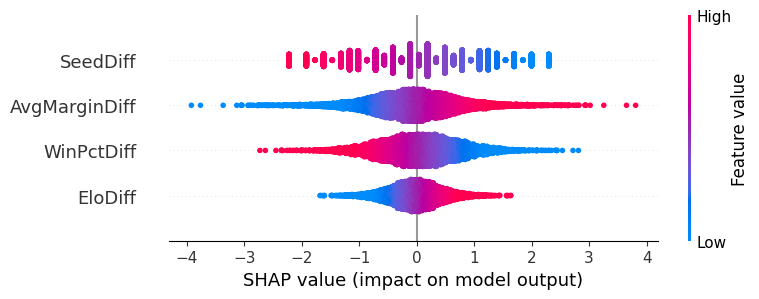

In [10]:
# SHAP Analysis for the final features
final_features = ['SeedDiff', 'WinPctDiff', 'AvgMarginDiff', 'EloDiff']
X_final = updated_X[final_features]
y_final = updated_y
masker = shap.maskers.Independent(data=X_final)
final_clf = LogisticRegression(solver='liblinear')
final_clf.fit(X_final, y_final)
explainer = shap.LinearExplainer(model=final_clf, data=X_final, masker=masker)
shap_values = explainer.shap_values(X_final)
shap.summary_plot(shap_values, X_final)

Step 4: Weighted Decay CV Experiments


Weighted Decay (Phase 3 Combined Basic Model):
λ=0.500: Avg Brier = 0.1749
λ=0.510: Avg Brier = 0.1749
λ=0.520: Avg Brier = 0.1748
λ=0.530: Avg Brier = 0.1748
λ=0.540: Avg Brier = 0.1748
λ=0.550: Avg Brier = 0.1748
λ=0.560: Avg Brier = 0.1748
λ=0.570: Avg Brier = 0.1747
λ=0.580: Avg Brier = 0.1747
λ=0.590: Avg Brier = 0.1747
λ=0.600: Avg Brier = 0.1747
λ=0.610: Avg Brier = 0.1747
λ=0.620: Avg Brier = 0.1747
λ=0.630: Avg Brier = 0.1746
λ=0.640: Avg Brier = 0.1746
λ=0.650: Avg Brier = 0.1746
λ=0.660: Avg Brier = 0.1746
λ=0.670: Avg Brier = 0.1746
λ=0.680: Avg Brier = 0.1746
λ=0.690: Avg Brier = 0.1745
λ=0.700: Avg Brier = 0.1745
λ=0.710: Avg Brier = 0.1745
λ=0.720: Avg Brier = 0.1745
λ=0.730: Avg Brier = 0.1745
λ=0.740: Avg Brier = 0.1745
λ=0.750: Avg Brier = 0.1744
λ=0.760: Avg Brier = 0.1744
λ=0.770: Avg Brier = 0.1744
λ=0.780: Avg Brier = 0.1744
λ=0.790: Avg Brier = 0.1744
λ=0.800: Avg Brier = 0.1743
λ=0.810: Avg Brier = 0.1743
λ=0.820: Avg Brier = 0.1743
λ=0.830: Avg Brier = 0.1743


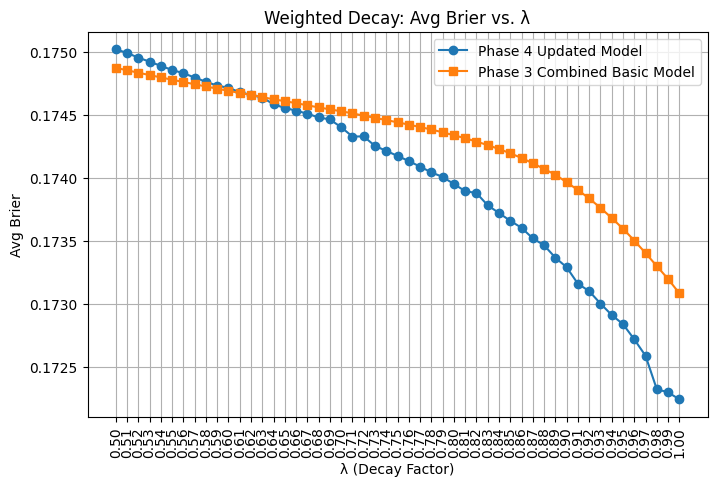

In [11]:
# We now incorporate weighted decay into CV by computing sample weights based on a decay factor.
# The new rolling_window_cv function is used so that the predictor matrix **X** does not include the target.

def lambda_sample_weight_fn(X_train_full, test_season, lambda_val, tol=1e-8):
    """
    Computes elementwise sample weights based on decay factor lambda_val.
    For each training sample, weight = lambda_val^(test_season - training_sample_season).
    
    If X_train_full is empty, returns an empty array.
    If lambda_val is within tol of 1, returns None (i.e. no weighting).
    """
    if X_train_full.empty:
        return np.array([])
    if abs(lambda_val - 1.0) < tol:
        return None
    # Compute weights elementwise (using the 'Season' column of each training sample)
    weights = lambda_val ** (test_season - X_train_full['Season'])
    return weights.to_numpy()

def run_weighted_decay_experiment(X_df, y_series, features, lambda_val, start_season, window_size=None):
    """
    Runs a weighted decay experiment using rolling_window_cv.
    The feature matrix is built from "Season" plus predictor features (excluding the target).
    """
    sample_weight_fn = lambda X_train_full, test_season: lambda_sample_weight_fn(X_train_full, test_season, lambda_val)
    return rolling_window_cv(
        X = X_df[["Season"] + features],
        y = y_series,
        start_season = start_season,
        window_size = window_size,
        model_fn = lr_model_fn,
        sample_weight_fn = sample_weight_fn,
        verbose = False
    )

lambda_range = np.linspace(0.5, 1.0, 51)

decay_cv_results_basic = {}
for lam in lambda_range:
    cv_metrics = run_weighted_decay_experiment(combined_X, combined_y, features_baseline, lam, start_season, window_size=None)
    # Save the average Brier score across test seasons
    decay_cv_results_basic[lam] = cv_metrics["brier"].mean()

optimal_lambda_basic = min(decay_cv_results_basic, key=lambda k: decay_cv_results_basic[k])
print("\nWeighted Decay (Phase 3 Combined Basic Model):")
for lam, bri in decay_cv_results_basic.items():
    print(f"λ={lam:.3f}: Avg Brier = {bri:.4f}")
print(f"Optimal λ (Basic) = {optimal_lambda_basic:.3f} with Avg Brier = {decay_cv_results_basic[optimal_lambda_basic]:.4f}")

# For the Updated Model (with EloDiff), using the updated dataset:
decay_cv_results_updated = {}
for lam in lambda_range:
    cv_metrics = rolling_window_cv(
        X = updated_X[["Season", "SeedDiff", "WinPctDiff", "AvgMarginDiff", "EloDiff"]],
        y = updated_y,
        start_season = start_season,
        window_size = None,
        model_fn = lr_model_fn,
        sample_weight_fn = lambda X_train_full, test_season: lambda_sample_weight_fn(X_train_full, test_season, lam),
        verbose = False
    )
    decay_cv_results_updated[lam] = cv_metrics["brier"].mean()

optimal_lambda_updated = min(decay_cv_results_updated, key=lambda k: decay_cv_results_updated[k])
print("\nWeighted Decay (Phase 4 Updated Model):")
for lam, bri in decay_cv_results_updated.items():
    print(f"λ={lam:.3f}: Avg Brier = {bri:.4f}")
print(f"Optimal λ (Updated) = {optimal_lambda_updated:.3f} with Avg Brier = {decay_cv_results_updated[optimal_lambda_updated]:.4f}")

# Optionally, plot the weighted decay results.
plt.figure(figsize=(8, 5))
# Plot Phase 4 Updated Model first (marker 'o')
lam_vals_updated = sorted(decay_cv_results_updated.keys())
loss_vals_updated = [decay_cv_results_updated[lam] for lam in lam_vals_updated]
plt.plot(lam_vals_updated, loss_vals_updated, marker='o', label="Phase 4 Updated Model")
# Then plot Phase 3 Combined Basic Model (marker 's')
lam_vals_basic = sorted(decay_cv_results_basic.keys())
loss_vals_basic = [decay_cv_results_basic[lam] for lam in lam_vals_basic]
plt.plot(lam_vals_basic, loss_vals_basic, marker='s', label="Phase 3 Combined Basic Model")
plt.title("Weighted Decay: Avg Brier vs. λ")
plt.xlabel("λ (Decay Factor)")
plt.ylabel("Avg Brier")
plt.xticks(lam_vals_basic, rotation=90)
plt.grid(True)
plt.legend()
plt.show()

Step 5: Final Comparison with Data Cut from Candidate Years

In [12]:
# Determine candidate cut years starting from the earliest season in the combined dataset.
earliest_year = int(combined_X["Season"].min())
latest_year = start_season  # or set to your desired maximum
candidate_cut_years = list(range(earliest_year, latest_year + 1))

results_cut = {}

for cut_year in candidate_cut_years:
    # Filter the datasets so that only seasons >= cut_year remain.
    data_basic_X_cut = combined_X[combined_X['Season'] >= cut_year].copy()
    data_basic_y_cut = combined_y[combined_X['Season'] >= cut_year].copy()
    data_updated_X_cut = updated_X[updated_X['Season'] >= cut_year].copy()
    data_updated_y_cut = updated_y[updated_X['Season'] >= cut_year].copy()
    
    # Determine valid test seasons from the candidate-cut data.
    valid_seasons_cut = sorted(data_basic_X_cut['Season'].unique())
    # We need at least two seasons (one training and one test) to run CV.
    if data_basic_X_cut.empty or len(valid_seasons_cut) < 2:
        continue

    # Use the global start_season only if it is not below the data's minimum;
    # otherwise, use the data's minimum season.
    cv_start_season_basic = max(start_season, data_basic_X_cut['Season'].min())
    cv_start_season_updated = max(start_season, data_updated_X_cut['Season'].min())

    # Run CV using the candidate-cut data.
    cv_metrics_basic = rolling_window_cv(
        X = data_basic_X_cut[["Season"] + features_baseline],
        y = data_basic_y_cut,
        start_season = cv_start_season_basic,
        window_size = None,
        model_fn = lr_model_fn,
        verbose = False
    )
    
    cv_metrics_updated = rolling_window_cv(
        X = data_updated_X_cut[["Season", "SeedDiff", "WinPctDiff", "AvgMarginDiff", "EloDiff"]],
        y = data_updated_y_cut,
        start_season = cv_start_season_updated,
        window_size = None,
        model_fn = lr_model_fn,
        verbose = False
    )
    
    results_cut[cut_year] = {'basic': cv_metrics_basic, 'updated': cv_metrics_updated}

if results_cut:
    # Safely access brier scores if they exist, otherwise use a very high default value
    def get_mean_brier(metrics):
        # Check if metrics is a DataFrame with 'brier' column
        if isinstance(metrics, pd.DataFrame) and 'brier' in metrics.columns:
            return metrics['brier'].mean()
        # Check if metrics is a dict with 'brier' key
        elif isinstance(metrics, dict) and 'brier' in metrics:
            return metrics['brier'].mean() if hasattr(metrics['brier'], 'mean') else metrics['brier']
        # Default fallback
        return float('inf')
    
    # Choose the candidate cut year that gives the lowest average Brier
    best_cut_basic = min(results_cut.items(), key=lambda x: get_mean_brier(x[1]['basic']))[0]
    best_cut_updated = min(results_cut.items(), key=lambda x: get_mean_brier(x[1]['updated']))[0]
    
    print("\n--- Final Comparison with Data Cut from the Best Year Onwards ---")
    print("For Combined Basic Model:")
    metrics_basic = results_cut[best_cut_basic]['basic']
    print(f"Best cut year: {best_cut_basic}")
    
    # Safely print metrics based on their structure
    if isinstance(metrics_basic, pd.DataFrame) and all(col in metrics_basic.columns for col in ['accuracy', 'logloss', 'brier']):
        print(f"CV Metrics: Accuracy = {metrics_basic['accuracy'].mean():.4f}, Log Loss = {metrics_basic['logloss'].mean():.4f}, Brier = {metrics_basic['brier'].mean():.4f}")
    elif isinstance(metrics_basic, dict) and all(key in metrics_basic for key in ['accuracy', 'logloss', 'brier']):
        print(f"CV Metrics: Accuracy = {metrics_basic['accuracy'].mean() if hasattr(metrics_basic['accuracy'], 'mean') else metrics_basic['accuracy']:.4f}, ",
              f"Log Loss = {metrics_basic['logloss'].mean() if hasattr(metrics_basic['logloss'], 'mean') else metrics_basic['logloss']:.4f}, ",
              f"Brier = {metrics_basic['brier'].mean() if hasattr(metrics_basic['brier'], 'mean') else metrics_basic['brier']:.4f}")
    else:
        print("Metrics structure not as expected. Please inspect metrics_basic.")
        print(metrics_basic)
    
    print("\nFor Updated Model:")
    metrics_updated = results_cut[best_cut_updated]['updated']
    print(f"Best cut year: {best_cut_updated}")
    
    # Safely print metrics based on their structure
    if isinstance(metrics_updated, pd.DataFrame) and all(col in metrics_updated.columns for col in ['accuracy', 'logloss', 'brier']):
        print(f"CV Metrics: Accuracy = {metrics_updated['accuracy'].mean():.4f}, Log Loss = {metrics_updated['logloss'].mean():.4f}, Brier = {metrics_updated['brier'].mean():.4f}")
    elif isinstance(metrics_updated, dict) and all(key in metrics_updated for key in ['accuracy', 'logloss', 'brier']):
        print(f"CV Metrics: Accuracy = {metrics_updated['accuracy'].mean() if hasattr(metrics_updated['accuracy'], 'mean') else metrics_updated['accuracy']:.4f}, ",
              f"Log Loss = {metrics_updated['logloss'].mean() if hasattr(metrics_updated['logloss'], 'mean') else metrics_updated['logloss']:.4f}, ",
              f"Brier = {metrics_updated['brier'].mean() if hasattr(metrics_updated['brier'], 'mean') else metrics_updated['brier']:.4f}")
    else:
        print("Metrics structure not as expected. Please inspect metrics_updated.")
        print(metrics_updated)
else:
    print("Not enough data available for a data cut comparison.")


--- Final Comparison with Data Cut from the Best Year Onwards ---
For Combined Basic Model:
Best cut year: 1985
CV Metrics: Accuracy = 0.7444, Log Loss = 0.5128, Brier = 0.1731

For Updated Model:
Best cut year: 1985
CV Metrics: Accuracy = 0.7398, Log Loss = 0.5104, Brier = 0.1722


Step 6: Hyperparameter Tuning for Logistic Regression

In [13]:
# We now use Optuna to tune hyperparameters (penalty and C) for our Logistic Regression model.
# The objective function is updated to use the new rolling_window_cv function.
# Valid seasons for Phase 3 and Phase 4 are chosen as in your original notebook.

import optuna

def objective(trial, X_df, y_series, features, valid_seasons):
    # Suggest hyperparameters for Logistic Regression.
    # If 'l1' is chosen, our lr_model_fn will enforce solver='liblinear'.
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    model_params = {"penalty": penalty, "C": C, "max_iter": 2000}
    
    cv_metrics = rolling_window_cv(
        X = X_df[["Season"] + features],
        y = y_series,
        start_season = valid_seasons[0],
        window_size = None,
        model_fn = lr_model_fn,
        model_params = model_params,
        verbose = False
    )
    avg_brier = cv_metrics["brier"].mean()
    return avg_brier

# For the Combined Basic Model, use the best candidate cut year from Step 5.
# Assume 'best_cut_basic' was obtained in Step 5.
phase3_X = combined_X[combined_X['Season'] >= best_cut_basic].copy()
phase3_y = combined_y[combined_X['Season'] >= best_cut_basic].copy()
phase3_valid_seasons = sorted(phase3_X['Season'].unique())
study_phase3 = optuna.create_study(direction="minimize", study_name="phase3_basic")
study_phase3.optimize(lambda trial: objective(trial, X_df=phase3_X, y_series=phase3_y, features=features_baseline, valid_seasons=phase3_valid_seasons), n_trials=50)
best_trial_phase3 = study_phase3.best_trial
print("Best Hyperparameters for Combined Basic Model:", best_trial_phase3.params)
print("Best Brier:", best_trial_phase3.value)

# For the Updated Model, use the best candidate cut year from Step 5.
# Assume 'best_cut_updated' was obtained in Step 5.
phase4_X = updated_X[updated_X['Season'] >= best_cut_updated].copy()
phase4_y = updated_y[updated_X['Season'] >= best_cut_updated].copy()
phase4_valid_seasons = sorted(phase4_X['Season'].unique())
study_phase4 = optuna.create_study(direction="minimize", study_name="phase4_updated")
study_phase4.optimize(lambda trial: objective(trial, X_df=phase4_X, y_series=phase4_y, features=['SeedDiff', 'WinPctDiff', 'AvgMarginDiff', 'EloDiff'], valid_seasons=phase4_valid_seasons), n_trials=50)
best_trial_phase4 = study_phase4.best_trial
print("Best Hyperparameters for Updated Model:", best_trial_phase4.params)
print("Best Brier:", best_trial_phase4.value)

[I 2025-05-11 14:04:08,947] A new study created in memory with name: phase3_basic
[I 2025-05-11 14:04:09,183] Trial 0 finished with value: 0.17218951793104256 and parameters: {'penalty': 'l1', 'C': 13.231091224641181}. Best is trial 0 with value: 0.17218951793104256.
[I 2025-05-11 14:04:09,406] Trial 1 finished with value: 0.17219050020964324 and parameters: {'penalty': 'l1', 'C': 2.789893205114802}. Best is trial 0 with value: 0.17218951793104256.
[I 2025-05-11 14:04:09,687] Trial 2 finished with value: 0.1721438426390951 and parameters: {'penalty': 'l2', 'C': 2.2317014279529364}. Best is trial 2 with value: 0.1721438426390951.
[I 2025-05-11 14:04:09,869] Trial 3 finished with value: 0.17276856031913457 and parameters: {'penalty': 'l2', 'C': 0.016894841200041116}. Best is trial 2 with value: 0.1721438426390951.
[I 2025-05-11 14:04:10,061] Trial 4 finished with value: 0.17222914555414634 and parameters: {'penalty': 'l1', 'C': 87.70553740821397}. Best is trial 2 with value: 0.1721438426

Best Hyperparameters for Combined Basic Model: {'penalty': 'l2', 'C': 3.181366589472408}
Best Brier: 0.1721428820457105


[I 2025-05-11 14:04:19,810] Trial 0 finished with value: 0.171381064405774 and parameters: {'penalty': 'l1', 'C': 7.013133886614008}. Best is trial 0 with value: 0.171381064405774.
[I 2025-05-11 14:04:20,069] Trial 1 finished with value: 0.1713255593886077 and parameters: {'penalty': 'l2', 'C': 2.7582985855731095}. Best is trial 1 with value: 0.1713255593886077.
[I 2025-05-11 14:04:20,290] Trial 2 finished with value: 0.17245265120339048 and parameters: {'penalty': 'l1', 'C': 0.042761365354775906}. Best is trial 1 with value: 0.1713255593886077.
[I 2025-05-11 14:04:20,666] Trial 3 finished with value: 0.17262542483732668 and parameters: {'penalty': 'l1', 'C': 0.02200957568571565}. Best is trial 1 with value: 0.1713255593886077.
[I 2025-05-11 14:04:20,907] Trial 4 finished with value: 0.17247923296908782 and parameters: {'penalty': 'l1', 'C': 0.036189768716636934}. Best is trial 1 with value: 0.1713255593886077.
[I 2025-05-11 14:04:21,212] Trial 5 finished with value: 0.1711601436186063

Best Hyperparameters for Updated Model: {'penalty': 'l2', 'C': 9.882009159425802}
Best Brier: 0.17110270524230906


# Step 7: Model Persistence

Save the final trained model and predictions for ensemble methods.

In [15]:
# -------------------------------------------------------
#  Incremental train → predict loop  (2022 / 2023 / 2024)
# -------------------------------------------------------
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from pre_processing import generate_matchup_matrix

# 1) locate project-root/preds (not inside notebooks/)
import os

if os.path.exists("/kaggle/input"):
    preds_dir = Path("/kaggle/working/predictions")
else:
    preds_dir = Path(os.getcwd()).parent.parent / "predictions"



# Use the best parameters found by Optuna in Step 6
base_params = {**best_trial_phase4.params, "max_iter": 2000}
if base_params.get("penalty") == "l1" and "solver" not in base_params:
    base_params["solver"] = "liblinear"

for season in (2022, 2023, 2024):
    # -- TRAIN on all data *before* this season ---------------------------
    train_mask = updated_X["Season"] < season
    X_train = updated_X.loc[train_mask, final_features]
    y_train = updated_y.loc[train_mask]

    # Train the final model directly on the raw features
    clf = LogisticRegression(**base_params).fit(X_train, y_train)

    # -- PREDICT both brackets -------------------------------------------
    all_dfs = []
    for gender in ("M", "W"):
        X_pred, game_ids = generate_matchup_matrix("lr", season, gender=gender)

        # Get predictions directly using the final features
        y_hat = clf.predict_proba(X_pred[final_features])[:, 1]
        
        # Min-max normalization of the probabilities (optional)
        y_hat = (y_hat - y_hat.min()) / (y_hat.max() - y_hat.min() + 1e-8)
        
        all_dfs.append(pd.DataFrame({
            "Season":     season,
            "GameID":     game_ids,
            "y_hat_proba": y_hat
        }))

    df_out = pd.concat(all_dfs, ignore_index=True)
    fname  = preds_dir / f"predictions_{season}_lr.csv"
    df_out.to_csv(fname, index=False)

    n_train = train_mask.sum()
    n_pred  = len(df_out)
    print(f"{season}: trained on {n_train:>4} rows → {n_pred:>4} preds  |  saved → {fname}")

2022: trained on 7532 rows → 4556 preds  |  saved → /home/timkushmar/MLfinals/March_Madness_2024/predictions/predictions_2022_lr.csv
2023: trained on 7800 rows → 4556 preds  |  saved → /home/timkushmar/MLfinals/March_Madness_2024/predictions/predictions_2023_lr.csv
2024: trained on 8068 rows → 4556 preds  |  saved → /home/timkushmar/MLfinals/March_Madness_2024/predictions/predictions_2024_lr.csv
